In [52]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# import seaborn as sns
# sns.set(0)
import numpy.random as rnd
%matplotlib inline

In [53]:
edges = np.loadtxt("fb_Princeton.txt", skiprows=4, dtype="i8,i8")
G = nx.Graph()
G.add_edges_from(edges)

In [54]:
k = nx.degree(G)
e = nx.edges(G)

common information about Graph:
number of vertices and edges; number of conntected components:

In [55]:
degrees = np.array(list(k.values()))
len(degrees), len(e), nx.number_connected_components(G)

(6596, 293320, 10)

Distribution of degrees:

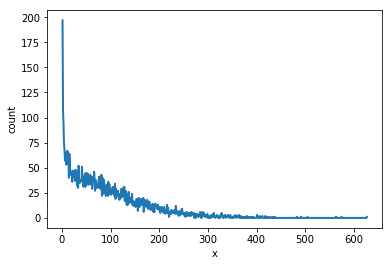

In [56]:
yh0, binEdges=np.histogram(degrees, bins=627)
bincenters0 = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(np.arange(1, max(degrees)), yh0, '-', lw=2)
plt.ylabel('count')
plt.xlabel('x')

Plot pdf

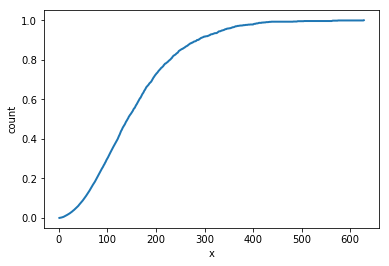

In [75]:
cdf = []
for cur_degree in range(1, max(degrees) + 1):
    cdf.append(sum([x if x <= cur_degree else 0 for x in degrees]))
cdf = [i / max(cdf) for i in cdf]
plt.plot(np.arange(1, max(degrees) + 1), cdf, '-', lw=2)
plt.ylabel('count')
plt.xlabel('x')

# Task 1

Degree distribution in loglog-scale

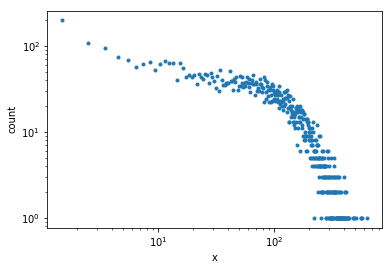

In [59]:
plt.loglog(bincenters0, yh0, '.', lw=2)
plt.ylabel('count')
plt.xlabel('x')

That distribution isn't nice. Let's take some value for xmin to build a regression:

In [60]:
my_xmin_index = 55

In [61]:
bincenters = bincenters0[55:]
yh = yh0[55:]

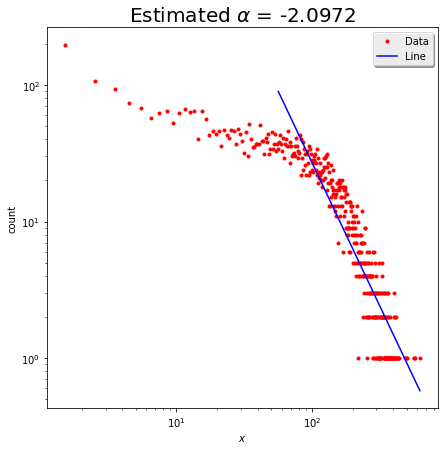

In [62]:
idx = np.ix_(yh != 0)
x_est = np.log(bincenters[idx])
y_est = np.log(yh[idx])
s = len(x_est)

# Do estimation
X = np.vstack([np.ones(s), x_est]).T
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

# Plot
idx = np.argsort(x_est)
yt = np.exp(X[idx,:].dot(Beta))
xt = np.exp(X[idx,1])

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.loglog(bincenters0, yh0, '.r', label='Data') 
ax.loglog(xt, yt, 'b', label='Line')
plt.ylabel('count')
plt.xlabel('$x$')
ax.legend(loc='upper right', shadow=True)
plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(Beta[1]), fontsize=20)

$b$ and $k$ coefficients of linear regression ($k*x + b$)

In [63]:
Beta

array([ 12.9585665 ,  -2.09717025])

Linear regression of x looks like $log(x)=-\alpha log(x) + log(C)$, so:

In [64]:
C = np.exp(Beta[0])
alpha = -Beta[1]

$x_{min}=(\frac{C}{\alpha - 1})^{\frac1{\alpha-1}}$, so:

In [65]:
xmin = (C / (alpha - 1)) ** (1 / (alpha - 1))
xmin, alpha, C

(123794.36363319299, 2.0971702524078744, 424457.21956934838)

Easy to see, that this xmin is not good; obviously this value is greater than any degree from graph. However, we have found suitable alpha

# Task 2

Anyway, we are able to find max and average number of in- and out- edges. Graph is undirected, so parameters for in- and out- edges is equal.

In [66]:
max(degrees), np.mean(degrees)

(628, 88.938750758035169)

# Task 3

We know $x_min$, so it is easy to find $\alpha$ by formula $\alpha = 1 + n[\sum_{i=1}^n ln(\frac{x_i}{x_{min}})]^{-1}$

In [67]:
def find_alpha(degrees, xmin):
    sum_degree = sum([np.log(xi/xmin) if xi > xmin else 0 for xi in degrees])
    alpha = 1 + len(degrees) * sum_degree ** (-1)
    return alpha

Now we can take some xmin (35, for example) and find alpha:

In [68]:
find_alpha(degrees, 35)

2.3285634905403247

# Task 4

Now we are going to take different xmin; for each of them alpha and C are easy to find with:

$\alpha = 1 + n[\sum_{i=1}^n ln(\frac{x_i}{x_{min}})]^{-1}$

$C = (\alpha - 1) \cdot x_{min}^{(\alpha - 1)}$

After this analytical CDF is easy to compute and be compared with empirical (which is called cdf in my notebook)

In [80]:
minmaxdiff = 99999999
for xmin in range(1, max(degrees)):
    alpha = find_alpha(degrees, xmin)
    C = (alpha - 1) * (xmin ** (alpha - 1))
    max_diff = 0
    for x in range(1, max(degrees)):
        Fx = 1 - (xmin / x) ** (alpha-1)
        cur_diff = np.absolute(Fx - cdf[x-1])
        if max_diff < cur_diff:
            max_diff = cur_diff
            cur_x = x
    print("xmin =",xmin, "max_diff=", max_diff, "alpha = ", alpha, "C = ", C)
    if minmaxdiff > max_diff and max_diff > 0 and max_diff != np.inf:
        minmaxdiff = max_diff
        best_alpha, best_C, best_xmin, best_x = alpha, C, xmin, cur_x


xmin = 1 max_diff= 0.548442842365 alpha =  1.255330766 C =  0.255330765998
xmin = 2 max_diff= 0.541191262585 alpha =  1.30825729827 C =  0.381687608558
xmin = 3 max_diff= 0.536132659869 alpha =  1.34998498778 C =  0.514084716479
xmin = 4 max_diff= 0.709289847558 alpha =  1.38655679777 C =  0.660607800018
xmin = 5 max_diff= 0.966925351335 alpha =  1.42020934117 C =  0.826379295215
xmin = 6 max_diff= 1.24797862977 alpha =  1.4520037678 C =  1.01594302289
xmin = 7 max_diff= 1.5579317098 alpha =  1.48258534228 C =  1.23425829238
xmin = 8 max_diff= 1.90203800662 alpha =  1.51229982067 C =  1.4865415146
xmin = 9 max_diff= 2.28589268736 alpha =  1.54138123653 C =  1.77873884457
xmin = 10 max_diff= 2.71626625603 alpha =  1.57006757628 C =  2.1183314626
xmin = 11 max_diff= 3.2000386939 alpha =  1.59844722869 C =  2.51330055175
xmin = 12 max_diff= 3.74502585891 alpha =  1.62659340072 C =  2.97299147265
xmin = 13 max_diff= 4.3606319079 alpha =  1.65460131237 C =  3.50885685993
xmin = 14 max_diff=

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: overflow encountered in double_scalars


xmin = 284 max_diff= inf alpha =  208.016320653 C =  inf
xmin = 285 max_diff= inf alpha =  211.996601208 C =  inf
xmin = 286 max_diff= inf alpha =  216.04447264 C =  inf
xmin = 287 max_diff= inf alpha =  220.235727436 C =  inf
xmin = 288 max_diff= inf alpha =  224.578148255 C =  inf
xmin = 289 max_diff= inf alpha =  229.025430552 C =  inf
xmin = 290 max_diff= inf alpha =  233.466993096 C =  inf
xmin = 291 max_diff= inf alpha =  238.010163219 C =  inf
xmin = 292 max_diff= inf alpha =  242.626792223 C =  inf
xmin = 293 max_diff= inf alpha =  247.252855058 C =  inf
xmin = 294 max_diff= inf alpha =  251.977724747 C =  inf
xmin = 295 max_diff= inf alpha =  256.836758634 C =  inf
xmin = 296 max_diff= inf alpha =  261.765521072 C =  inf
xmin = 297 max_diff= inf alpha =  266.798039245 C =  inf
xmin = 298 max_diff= inf alpha =  271.973274989 C =  inf
xmin = 299 max_diff= inf alpha =  277.219357059 C =  inf
xmin = 300 max_diff= inf alpha =  282.493479124 C =  inf
xmin = 301 max_diff= inf alpha =

In [83]:
print("xmin =", best_xmin, "max_diff=", minmaxdiff, "alpha = ", best_alpha, "C = ", best_C)

xmin = 3 max_diff= 0.536132659869 alpha =  1.34998498778 C =  0.514084716479


Unfortunately, C became too high to calculate further. However, $x_{min}$ is found and it is 3.